In [ ]:
# import libraries
from os import listdir
from os.path import isdir, join
import librosa
import librosa.display
import random
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
#!pip install  python_speech_features
import python_speech_features
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications  import VGG16,MobileNet
from tensorflow.keras.utils import to_categorical
import cv2
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Dataset path and view possible targets
dataset_path = 'data'

In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]

In [4]:
# Leave off background noise set
all_targets.remove('_background_noise_')

In [5]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

Total samples: 105829


In [6]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

In [8]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [9]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [10]:
# Only keep the specified number of samples (shorter extraction/training) use 100% by default
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

105829
105829


In [11]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [12]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [13]:

# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]


In [14]:

# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

go


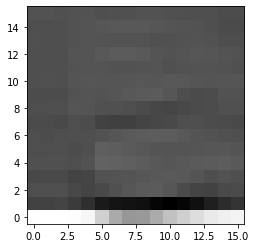

In [15]:
# TEST: Test shorter MFCC
#!pip install playsound
from playsound import playsound

idx = 240

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)

fig = plt.figure()
# Plot signal 
#signal, fs = librosa.load(path, sr=sample_rate)
#librosa.display.waveplot(signal,fs)

# Plot MFCC
plt.imshow(mfccs, cmap='orange', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [16]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [17]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Removed percentage: 0.08462765015059352
Removed percentage: 0.0841995841995842
Removed percentage: 0.08665658665658665


In [18]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

# Load saved mfcc

In [19]:
# Settings
feature_sets_filename = 'all_targets_mfcc_sets.npz'

# Load feature sets
feature_sets = np.load(join(feature_sets_filename))

In [20]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [21]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77500, 16, 16)
(9691, 16, 16)
(9665, 16, 16)


In [22]:
def convert_commands(data,commands,all_targets):
    new_data = np.zeros(len(data))
    for i in range(len(data)):
        for j in commands:
            if all_targets[int(data[i])] == j:
                new_data[i] = commands.index(j)+1
    return new_data

In [23]:
commands = ["forward", "backward", "up", "down", "yes", "no","on", "off", "right", "left", "go","stop"]
y_train = convert_commands(y_train,commands,all_targets)
y_val = convert_commands(y_val,commands,all_targets)
y_test = convert_commands(y_test,commands,all_targets)

In [24]:
x_train = x_train[:,:,:, np.newaxis]
x_val = x_val[:, :,:, np.newaxis]
x_test = x_test[:,:,:, np.newaxis]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77500, 16, 16, 1)
(9691, 16, 16, 1)
(9665, 16, 16, 1)


In [25]:
y_train = to_categorical(y_train,13)
y_val = to_categorical(y_val,13)
y_test = to_categorical(y_test,13)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(77500, 13)
(9691, 13)
(9665, 13)


# Single Layer perceptron

In [26]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val_flat = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(77500, 256)
(9665, 256)


In [27]:
slp = models.Sequential([
  layers.Dense(13, activation='softmax'),
])

In [28]:
slp.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
es = EarlyStopping(patience = 10, monitor='val_loss')
mc_slp = ModelCheckpoint('best_model_slp.h5', monitor='val_loss')
history_slp = slp.fit(x_train_flat, y_train,
                epochs=9999,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_flat, y_val),
                callbacks = [es,mc_slp])

Epoch 1/9999
303/303 [==============================] - 1s 2ms/step - loss: 3.9137 - acc: 0.4628 - val_loss: 1.8895 - val_acc: 0.5397
Epoch 2/9999
303/303 [==============================] - 1s 2ms/step - loss: 1.6595 - acc: 0.5629 - val_loss: 1.4925 - val_acc: 0.5773
Epoch 3/9999
303/303 [==============================] - 1s 2ms/step - loss: 1.4295 - acc: 0.5915 - val_loss: 1.3897 - val_acc: 0.5940
Epoch 4/9999
303/303 [==============================] - ETA: 0s - loss: 1.3549 - acc: 0.603 - 1s 2ms/step - loss: 1.3490 - acc: 0.6040 - val_loss: 1.3265 - val_acc: 0.6115
Epoch 5/9999
303/303 [==============================] - 1s 2ms/step - loss: 1.3071 - acc: 0.6120 - val_loss: 1.3208 - val_acc: 0.6154
Epoch 6/9999
303/303 [==============================] - 1s 2ms/step - loss: 1.2859 - acc: 0.6173 - val_loss: 1.2966 - val_acc: 0.6222
Epoch 7/9999
303/303 [==============================] - 1s 2ms/step - loss: 1.2709 - acc: 0.6199 - val_loss: 1.2792 - val_acc: 0.6245
Epoch 8/9999
303/303 [==

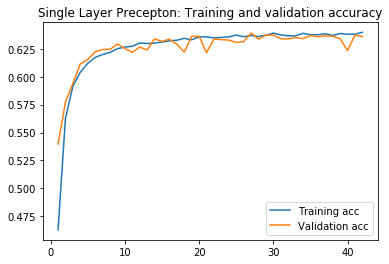

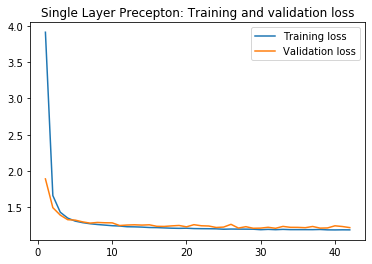

In [29]:
acc = history_slp.history['acc']
val_acc = history_slp.history['val_acc']
loss = history_slp.history['loss']
val_loss = history_slp.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Single Layer Precepton: Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Single Layer Precepton: Training and validation loss')
plt.legend()

plt.show()

In [30]:
test_eval = slp.evaluate(x_test_flat, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.208308219909668
Test accuracy: 0.6345576643943787


In [31]:
pred_test_slp = np.argmax(slp.predict(x_test_flat), axis=1)
y_test_slp= np.argmax(np.round(y_test),axis=1)

In [32]:
cmd = commands
cmd.insert(0,"other")
print(classification_report(y_test_slp, pred_test_slp, target_names=cmd))

              precision    recall  f1-score   support

       other       0.67      0.91      0.77      5861
     forward       0.48      0.19      0.27       129
    backward       0.66      0.25      0.37       150
          up       0.36      0.21      0.26       335
        down       0.36      0.17      0.23       345
         yes       0.48      0.38      0.43       388
          no       0.38      0.09      0.15       358
          on       0.60      0.22      0.32       365
         off       0.50      0.35      0.41       334
       right       0.45      0.12      0.19       354
        left       0.66      0.16      0.25       374
          go       0.30      0.04      0.07       336
        stop       0.48      0.29      0.36       336

    accuracy                           0.63      9665
   macro avg       0.49      0.26      0.31      9665
weighted avg       0.59      0.63      0.58      9665



In [33]:
print(confusion_matrix(y_test_slp,pred_test_slp)[1:13,1:13])

[[ 24   2   0   0   0   1   0   2   1   0   1   1]
 [  1  38   1   7   1   0   0   0   0   0   0   0]
 [  0   0  69   3   3   1   6  22   1   3   1  19]
 [  0   0   9  59   1   1   4   0   1   0   1   3]
 [  0   0   0   2 148   0   1   1   1   2   0   1]
 [  0   0   6   7   1  34   0   1   0   0   5   2]
 [  0   0   5  18   0   6  81  28   1   0   0   5]
 [  0   1  25   3   3   4  16 118   1   1   0  15]
 [  1   0   0   0   9   0   0   0  43   1   0   2]
 [  0   2   2   1  24   2   0   5   5  58   0   0]
 [  3   2   2   3   2   4   1   2   0   0  13   5]
 [  0   1  16   4   2   1   2   4   0   0   0  98]]


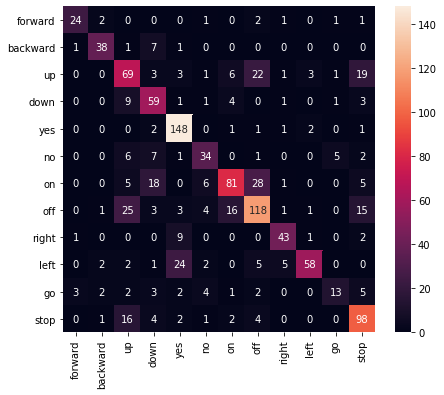

In [41]:
df_cm = pd.DataFrame(confusion_matrix(y_test_slp,pred_test_slp)[1:13,1:13], index = commands[1:13],columns = commands[1:13])
plt.figure(figsize = (7,6))
sn.heatmap(df_cm, annot=True, fmt='g')

# Dense Network

In [42]:
dense = models.Sequential([
  layers.Dense(128, activation='relu', input_shape=(256,)),
  layers.Dense(64, activation='relu'),
  layers.Dense(13, activation='softmax'),
])

In [43]:
dense.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 13)                845       
Total params: 41,997
Trainable params: 41,997
Non-trainable params: 0
_________________________________________________________________


In [44]:
dense.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
es = EarlyStopping(patience = 10, monitor='val_loss')
mc_dense = ModelCheckpoint('best_model_dense.h5', monitor='val_loss')
history_dense = dense.fit(x_train_flat, y_train,
                epochs=9999,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_flat, y_val),
                callbacks = [es,mc_dense])

Epoch 1/9999
303/303 [==============================] - 1s 2ms/step - loss: 1.4504 - acc: 0.6230 - val_loss: 0.9713 - val_acc: 0.6917
Epoch 2/9999
303/303 [==============================] - 1s 2ms/step - loss: 0.8512 - acc: 0.7300 - val_loss: 0.7771 - val_acc: 0.7542
Epoch 3/9999
303/303 [==============================] - 1s 2ms/step - loss: 0.7134 - acc: 0.7711 - val_loss: 0.7104 - val_acc: 0.7734
Epoch 4/9999
303/303 [==============================] - 1s 2ms/step - loss: 0.6412 - acc: 0.7937 - val_loss: 0.6522 - val_acc: 0.7953
Epoch 5/9999
303/303 [==============================] - 1s 2ms/step - loss: 0.5905 - acc: 0.8097 - val_loss: 0.6314 - val_acc: 0.7993
Epoch 6/9999
303/303 [==============================] - 1s 2ms/step - loss: 0.5504 - acc: 0.8219 - val_loss: 0.5942 - val_acc: 0.8122
Epoch 7/9999
303/303 [==============================] - 1s 2ms/step - loss: 0.5245 - acc: 0.8298 - val_loss: 0.5878 - val_acc: 0.8119
Epoch 8/9999
303/303 [==============================] - 1s 2ms

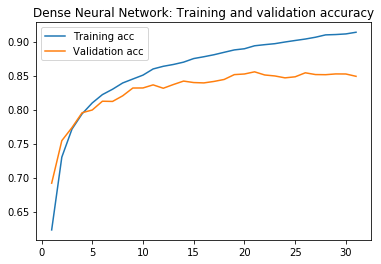

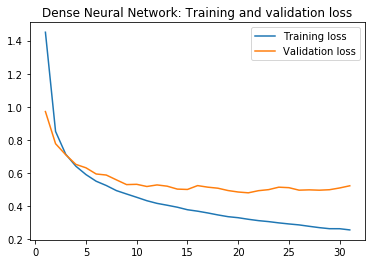

In [45]:
acc = history_dense.history['acc']
val_acc = history_dense.history['val_acc']
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Dense Neural Network: Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Dense Neural Network: Training and validation loss')
plt.legend()

plt.show()

In [46]:
test_eval = dense.evaluate(x_test_flat, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5105646848678589
Test accuracy: 0.8491464257240295


In [47]:
pred_test_dense = np.argmax(dense.predict(x_test_flat), axis=1)
y_test_dense = np.argmax(np.round(y_test),axis=1)

In [48]:
print(classification_report(y_test_dense, pred_test_dense, target_names=cmd))

              precision    recall  f1-score   support

       other       0.90      0.92      0.91      5861
     forward       0.75      0.53      0.62       129
    backward       0.82      0.89      0.86       150
          up       0.73      0.70      0.72       335
        down       0.83      0.65      0.73       345
         yes       0.92      0.76      0.83       388
          no       0.77      0.63      0.69       358
          on       0.70      0.75      0.73       365
         off       0.77      0.76      0.77       334
       right       0.76      0.82      0.79       354
        left       0.73      0.79      0.76       374
          go       0.63      0.73      0.68       336
        stop       0.85      0.76      0.80       336

    accuracy                           0.85      9665
   macro avg       0.78      0.75      0.76      9665
weighted avg       0.85      0.85      0.85      9665



In [49]:
print(confusion_matrix(y_test_dense,pred_test_dense)[1:13,1:13])

[[ 69   3   0   0   0   0   3   1   1   0   2   1]
 [  1 134   1   1   0   0   0   0   1   0   0   0]
 [  0   3 235   2   0   0  15  18   1   5   3   8]
 [  1   4   1 223   1  17   3   0   0   4   8   5]
 [  0   0   0   2 296   2   1   2   0  30   0   0]
 [  0   0   0   7   2 225   0   0   0   2  54   6]
 [  3   1   3   0   0   0 275  13   0   1   0   0]
 [  0   0  20   0   0   0  23 255   0   3   0   2]
 [  0   1   2   0   0   0   0   0 292   9   0   0]
 [  0   1   5   0  12   1   0   4  11 297   1   1]
 [  1   0   2   4   0  23   1   1   0   0 246   2]
 [  0   0  12   7   1   0   0   2   0   1   8 254]]


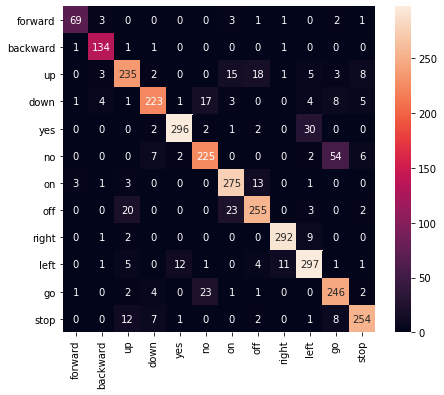

In [50]:
df_cm = pd.DataFrame(confusion_matrix(y_test_dense,pred_test_dense)[1:13,1:13], index = commands[1:13],columns = commands[1:13])
plt.figure(figsize = (7,6))
sn.heatmap(df_cm, annot=True, fmt='g')

# Convolutional

In [51]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape=(16,16,1)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(layers.Conv2D(64, (2, 2), activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(13, activation='softmax'))

In [52]:
# Display model
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                36928     
_________________________________________________________________
dropout (Dropout)            (None, 64)               

In [53]:
# Add training parameters to model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
es = EarlyStopping(patience = 10, monitor='val_loss')
mc_cnn = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss')

In [54]:
# Train
history_cnn = cnn_model.fit(x_train, 
                    y_train, 
                    epochs=9999, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks = [es,mc_cnn])

Epoch 1/9999
303/303 [==============================] - 1s 4ms/step - loss: 1.6322 - acc: 0.5930 - val_loss: 1.2516 - val_acc: 0.6124
Epoch 2/9999
303/303 [==============================] - 1s 3ms/step - loss: 1.2188 - acc: 0.6314 - val_loss: 0.9744 - val_acc: 0.6713
Epoch 3/9999
303/303 [==============================] - 1s 3ms/step - loss: 1.0499 - acc: 0.6675 - val_loss: 0.8473 - val_acc: 0.7121
Epoch 4/9999
303/303 [==============================] - 1s 3ms/step - loss: 0.9557 - acc: 0.6909 - val_loss: 0.7941 - val_acc: 0.7307
Epoch 5/9999
303/303 [==============================] - 1s 3ms/step - loss: 0.8843 - acc: 0.7129 - val_loss: 0.7359 - val_acc: 0.7514
Epoch 6/9999
303/303 [==============================] - 1s 3ms/step - loss: 0.8300 - acc: 0.7288 - val_loss: 0.6632 - val_acc: 0.7865
Epoch 7/9999
303/303 [==============================] - 1s 3ms/step - loss: 0.7792 - acc: 0.7455 - val_loss: 0.6279 - val_acc: 0.7947
Epoch 8/9999
303/303 [==============================] - 1s 3ms

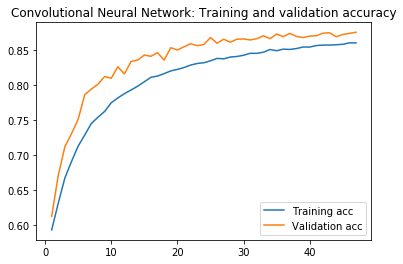

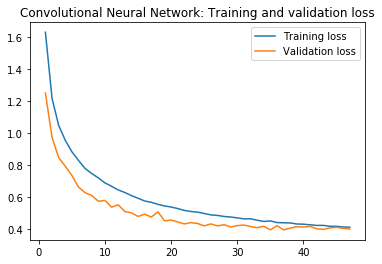

In [55]:
# Plot results

acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Convolutional Neural Network: Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Convolutional Neural Network: Training and validation loss')
plt.legend()

plt.show()

In [56]:
test_eval = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.3849329352378845
Test accuracy: 0.8810139894485474


In [57]:
pred_test_cnn = np.argmax(cnn_model.predict(x_test), axis=1)

In [58]:
y_test_cnn= np.argmax(np.round(y_test),axis=1)

In [59]:
print(classification_report(y_test_cnn, pred_test_cnn, target_names=cmd))

              precision    recall  f1-score   support

       other       0.89      0.97      0.92      5861
     forward       0.77      0.36      0.49       129
    backward       0.98      0.85      0.91       150
          up       0.85      0.71      0.77       335
        down       0.87      0.74      0.80       345
         yes       0.92      0.86      0.89       388
          no       0.78      0.74      0.76       358
          on       0.87      0.76      0.81       365
         off       0.85      0.75      0.80       334
       right       0.95      0.83      0.88       354
        left       0.95      0.75      0.84       374
          go       0.80      0.63      0.71       336
        stop       0.85      0.78      0.81       336

    accuracy                           0.88      9665
   macro avg       0.87      0.75      0.80      9665
weighted avg       0.88      0.88      0.88      9665



In [60]:
print(confusion_matrix(y_test_cnn,pred_test_cnn)[1:13,1:13])

[[ 47   0   0   0   0   0   2   0   1   0   0   0]
 [  0 127   1   0   0   0   0   0   0   0   0   0]
 [  0   0 239   0   0   2   4  22   0   1   0  15]
 [  0   0   1 256   0  13   1   0   0   0   5   0]
 [  0   0   0   0 334   1   0   0   0   2   0   0]
 [  0   0   0   9   3 264   0   0   0   0  16   4]
 [  0   0   4   0   0   0 279   5   1   0   0   0]
 [  0   0  14   0   0   0  12 251   0   0   2   2]
 [  0   1   0   0   0   0   0   0 294   1   0   0]
 [  0   0   2   0  14   1   0   2   7 281   0   0]
 [  1   0   1   7   0  31   0   1   0   0 213   4]
 [  0   0   2   4   0   0   2   1   0   1   1 262]]


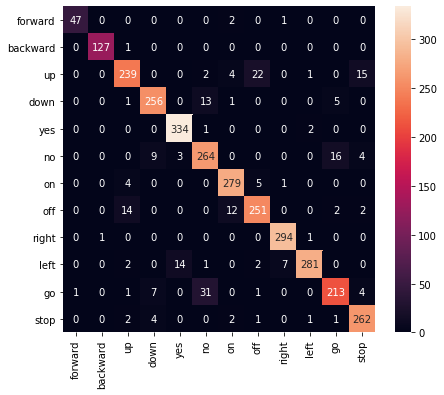

In [63]:
df_cm = pd.DataFrame(confusion_matrix(y_test_cnn,pred_test_cnn)[1:13,1:13], index = commands[1:13],columns = commands[1:13])
plt.figure(figsize = (7,6))
sn.heatmap(df_cm, annot=True, fmt='g')

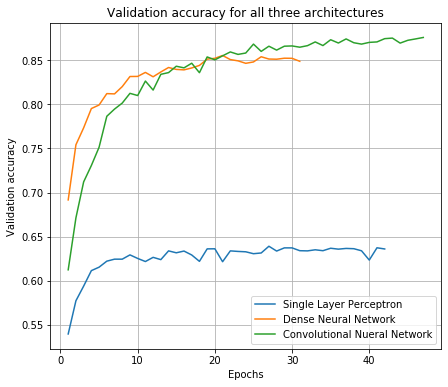

In [70]:
val_acc_slp = history_slp.history['val_acc']
val_acc_dense = history_dense.history['val_acc']
val_acc_cnn = history_cnn.history['val_acc']

epochs_slp = range(1, len(val_acc_slp) + 1)
epochs_dense = range(1, len(val_acc_dense) + 1)
epochs_cnn = range(1, len(val_acc_cnn) + 1)
plt.figure(figsize = (7,6))
plt.plot(epochs_slp, val_acc_slp, label='Single Layer Perceptron')
plt.plot(epochs_dense, val_acc_dense, label='Dense Neural Network')
plt.plot(epochs_cnn, val_acc_cnn, label='Convolutional Nueral Network')
plt.title('Validation accuracy for all three architectures')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Validation accuracy', fontsize=10)
plt.legend()
plt.grid()
plt.show()

# Additonal Experiment

In [71]:
cnn_model1 = models.Sequential()
cnn_model1.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape=(16,16,1)))
cnn_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model1.add(layers.Flatten())
cnn_model1.add(layers.Dense(64, activation='relu'))
cnn_model1.add(layers.Dropout(0.5))
cnn_model1.add(layers.Dense(13, activation='softmax'))
cnn_model1.summary()
# Add training parameters to model
cnn_model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
es = EarlyStopping(patience = 10, monitor='val_loss')
mc_cnn1 = ModelCheckpoint('best_model_cnn1.h5', monitor='val_loss')
# Train
history_cnn1 = cnn_model1.fit(x_train, 
                    y_train, 
                    epochs=9999, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks = [es,mc_cnn1])
test_eval1 = cnn_model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval1[0])
print('Test accuracy:', test_eval1[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                100416    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 13)                845       
Total params: 101,421
Trainable params: 101,421
Non-trainable params: 0
________________________________________________

In [72]:
cnn_model2 = models.Sequential()
cnn_model2.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape=(16,16,1)))
cnn_model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(layers.Conv2D(64, (2, 2), activation='relu'))
cnn_model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(64, activation='relu'))
cnn_model2.add(layers.Dropout(0.5))
cnn_model2.add(layers.Dense(13, activation='softmax'))
cnn_model2.summary()
# Add training parameters to model
cnn_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
es = EarlyStopping(patience = 10, monitor='val_loss')
mc_cnn2 = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss')
# Train
history_cnn2 = cnn_model2.fit(x_train, 
                    y_train, 
                    epochs=9999, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks = [es,mc_cnn2])
test_eval2 = cnn_model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval2[0])
print('Test accuracy:', test_eval2[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [73]:
cnn_model3 = models.Sequential()
cnn_model3.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape=(16,16,1)))
cnn_model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model3.add(layers.Conv2D(64, (2, 2), activation='relu'))
cnn_model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model3.add(layers.Conv2D(128, (2, 2), activation='relu'))
cnn_model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model3.add(layers.Flatten())
cnn_model3.add(layers.Dense(64, activation='relu'))
cnn_model3.add(layers.Dropout(0.5))
cnn_model3.add(layers.Dense(13, activation='softmax'))
cnn_model3.summary()
# Add training parameters to model
cnn_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
es = EarlyStopping(patience = 10, monitor='val_loss')
mc_cnn3 = ModelCheckpoint('best_model_cnn3.h5', monitor='val_loss')
# Train
history_cnn3 = cnn_model3.fit(x_train, 
                    y_train, 
                    epochs=9999, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks = [es,mc_cnn3])
test_eval3 = cnn_model3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval3[0])
print('Test accuracy:', test_eval3[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)          8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 128)         32896     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

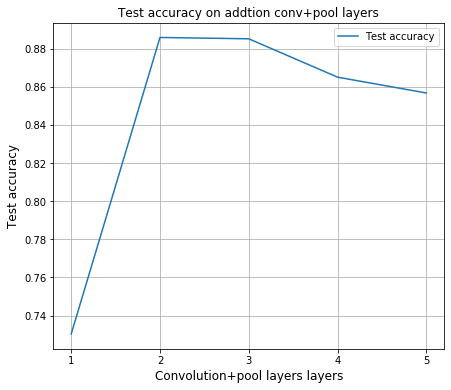

In [82]:
index = [1,2,3,4,5]
plt.figure(figsize = (7,6))
plt.plot(index, [0.7304,0.8858,0.8851,0.8650,0.8567], label='Test accuracy')
plt.title('Test accuracy on addtion conv+pool layers')
plt.xlabel('Convolution+pool layers layers', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.legend()
plt.xticks(index)
plt.grid()
plt.show()